# DNN Tuning Examples
**Make sure you have activated the correct python envorinment**

+ DNN = Dense Neural Network
+ Using the keras Sequential API and MNIST data

### Packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
np.random.seed(42)

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.initializers import RandomNormal, he_normal
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


### Data

MNIST is a dataset of 60,000 28x28 grayscale images of handwritten digits, along with a test set of 10,000 images.

Load the MNIST data using keras. The first time the data are downloaded and cached.  
Subsequent times the data are loaded from the cache.

True values: [4 0 0 8 3]


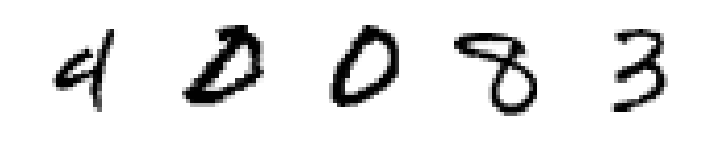

In [2]:
# load the date and split into training/testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# plot a few digits and print the true values
idigits = np.random.randint(0, len(y_train), 5)

fig = plt.figure(figsize=(12, 6))
for i in range(len(idigits)):
    ax = fig.add_subplot(1, len(idigits), i + 1)
    ax.imshow(x_train[idigits[i]], cmap = plt.cm.binary, interpolation="nearest")
    ax.axis("off")
print('True values: {}'.format(y_train[idigits]))

### Reshape, cast, normalize inputs
* Reshape the data: 28x28 -> 784  
* Cast the values int8 -> float32

In [3]:
n_classes = 10
n_train = len(x_train)  # 60000
n_test = len(x_test)  # 10000
input_dim = 28 * 28

x_train = x_train.reshape(n_train, input_dim)
x_train = x_train.astype(np.float32)
x_test = x_test.reshape(n_test, input_dim)
x_test = x_test.astype(np.float32)

x_train /= 255
x_test /= 255

### Convert the target values vector to binary class matrix
y_train is a vector of size 60,000.  
It gets mapped to a 60,000 x 10 matrix of 0s and 1s.

In [4]:
print("Targets before: \n{}".format(y_train[:5]))
ybm_train = to_categorical(y_train, n_classes)
ybm_test = to_categorical(y_test, n_classes)
print("Targets after: \n{}".format(ybm_train[:5]))

Targets before: 
[5 0 4 1 9]
Targets after: 
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Default DNN

In [5]:
# Define the common network parameters
# Number of hidden layers and units per layer
hidden = [100, 100]

In [6]:
nn1 = Sequential()
nn1.add(Dense(hidden[0], input_dim=input_dim, activation='relu'))
for i in range(len(hidden) - 1):
    nn1.add(Dense(hidden[i + 1], activation='relu'))
nn1.add(Dense(n_classes, activation='softmax'))
nn1.summary()

# the number of parameters is: n_classes x (input_dim + 1)
# each node has its own bias (therefore +1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


### Compile and fit the model

In [7]:
nn1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 1000
n_epochs = 40
val_split = 0.1 
# create an early stopping callback
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)

nn1_hist = nn1.fit(x_train, ybm_train, batch_size=batch_size, epochs=n_epochs, validation_split=val_split, callbacks=[es], verbose=1)
val_score = nn1.evaluate(x_test, ybm_test, verbose=0)

print('Default DNN')
print('------------------------')
print('Test loss score: {0:.4f}'.format(val_score[0]))
print('Test accuracy:   {0:.4f}'.format(val_score[1]))

Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - 1s 20us/step - loss: 2.2215 - acc: 0.2429 - val_loss: 2.0862 - val_acc: 0.3863
Epoch 2/40
54000/54000 [==============================] - 1s 15us/step - loss: 1.9558 - acc: 0.4678 - val_loss: 1.7983 - val_acc: 0.5668
Epoch 3/40
54000/54000 [==============================] - 1s 15us/step - loss: 1.6681 - acc: 0.6067 - val_loss: 1.4877 - val_acc: 0.6947
Epoch 4/40
54000/54000 [==============================] - 1s 15us/step - loss: 1.3793 - acc: 0.6979 - val_loss: 1.1990 - val_acc: 0.7638
Epoch 5/40
54000/54000 [==============================] - 1s 15us/step - loss: 1.1345 - acc: 0.7517 - val_loss: 0.9739 - val_acc: 0.8105
Epoch 6/40
54000/54000 [==============================] - 1s 15us/step - loss: 0.9540 - acc: 0.7844 - val_loss: 0.8150 - val_acc: 0.8348
Epoch 7/40
54000/54000 [==============================] - 1s 15us/step - loss: 0.8270 - acc: 0.8062 - val_loss: 0.7036 - val_acc:

## DNN with recommended settings

In [8]:
# Dropout rate
drop_rate = 0.4
# Create the initializer
# ini = RandomNormal()
ini = he_normal()

nn2 = Sequential()
nn2.add(Dense(hidden[0], input_dim=input_dim, activation='elu', kernel_initializer=ini))
nn2.add(Dropout(drop_rate))
for i in range(len(hidden) - 1):
    nn2.add(Dense(hidden[i + 1], activation='elu', kernel_initializer=ini))
    nn2.add(Dropout(drop_rate))    
nn2.add(Dense(n_classes, activation='softmax', kernel_initializer=ini))
nn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [9]:
# compile, fit and evaluate
nn2.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size2 = 1000
n_epochs2 = 40
val_split2 = 0.1 
# create an early stopping callback
es2 = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)

nn2_hist = nn2.fit(x_train, ybm_train, batch_size=batch_size2, epochs=n_epochs2, validation_split=val_split2, callbacks=[es2], verbose=1)
val_score = nn2.evaluate(x_test, ybm_test, verbose=0)

print('3-Layer DNN')
print('------------------------')
print('Test loss score: {0:.4f}'.format(val_score[0]))
print('Test accuracy:   {0:.4f}'.format(val_score[1]))


Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - 1s 26us/step - loss: 0.8116 - acc: 0.7426 - val_loss: 0.2613 - val_acc: 0.9297
Epoch 2/40
54000/54000 [==============================] - 1s 19us/step - loss: 0.4143 - acc: 0.8760 - val_loss: 0.2181 - val_acc: 0.9373
Epoch 3/40
54000/54000 [==============================] - 1s 19us/step - loss: 0.3620 - acc: 0.8930 - val_loss: 0.1962 - val_acc: 0.9435
Epoch 4/40
54000/54000 [==============================] - 1s 19us/step - loss: 0.3254 - acc: 0.9029 - val_loss: 0.1726 - val_acc: 0.9488
Epoch 5/40
54000/54000 [==============================] - 1s 18us/step - loss: 0.3009 - acc: 0.9111 - val_loss: 0.1612 - val_acc: 0.9548
Epoch 6/40
54000/54000 [==============================] - 1s 19us/step - loss: 0.2801 - acc: 0.9164 - val_loss: 0.1472 - val_acc: 0.9587
Epoch 7/40
54000/54000 [==============================] - 1s 19us/step - loss: 0.2625 - acc: 0.9217 - val_loss: 0.1354 - val_acc:

### Some predictions

In [10]:
nn2_pred = nn2.predict(x_test[:20])
nn2_ypred = np.argmax(nn2_pred, axis=1)

print('DNN predictions and true values')
display(nn2_ypred.tolist())
display(y_test[:20].tolist())

DNN predictions and true values


[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]

## Logistic Regression 

We fit a multiclass logistic regression model

In [11]:
lgm = LogisticRegression(C=1e-5, multi_class='multinomial', solver='lbfgs', max_iter=1000)
print(lgm)

LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


In [12]:
lgm.fit(x_train,  y_train)

LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [13]:
y_pred = lgm.predict(x_test)
lg_acc = accuracy_score(y_test, y_pred)
print('Logistic Regression')
print('------------------------')
print('Test accuracy:   {0:.4f}'.format(lg_acc))

Logistic Regression
------------------------
Test accuracy:   0.7482
